# Toxic Comment Classification Challenge

## Problem Statement
<p>
In this competition, the challenge is to build a multi-headed model that’s capable of detecting different types of toxicity like threats, obscenity, insults, and identity-based hate better than Perspective’s current models using a dataset of comments from Wikipedia’s talk page edits. Improvements to the current model will hopefully help online discussion become more productive and respectful.
</p>
<p>

<p>
They have provided with a large number of Wikipedia comments which have been labeled by human raters for toxic behavior. The types of toxicity are:
toxic
severe_toxic
obscene
threat
insult
identity_hate
The model should be able to predict the probability of each type of toxicity for each comment.
</p>


### Importing the necessary libaries

In [2]:
#Import the necessary modules

#Basic modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt1
from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm
from sklearn import metrics   #Additional scklearn functions   #Perforing grid search
import seaborn as sns
color = sns.color_palette()
import matplotlib.pylab as plt
import matplotlib.pyplot as plt2
from os import path
from PIL import Image


#Word analysis and normalization
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter
import re
import string
import os
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import contractions
import unicodedata
import spacy

#FeatureEngineering
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

#Model
from imblearn.over_sampling import SMOTE
from sklearn_pandas import DataFrameMapper
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss, classification_report

%matplotlib inline

/Users/abhinavmathur/anaconda3/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [3]:
#import sys
#print(sys.executable)
#path/to/python -m pip install some_package
#/anaconda3/bin/python -m pip install wordcloud
#/Users/abhinavmathur/anaconda3/bin/python -m pip install contractions

### Importing the files

In [4]:
#Import the files
#files provided - aisles, products,departments,orders_prior,orders

#test file
test = pd.read_csv('test.csv')
#importing the test labels file
test_labels= pd.read_csv('test_labels.csv')
#importing the train file
train =pd.read_csv("train.csv")

In [5]:
pd.set_option("display.max_colwidth", 10000)

### Data Exploration

In [6]:
train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,0,0,0,0,0
1,000103f0d9cfb60f,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember what page that's on?",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the tools well. · talk """,0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,"Your vandalism to the Matt Shirvington article has been reverted. Please don't do it again, or you will be banned.",0,0,0,0,0,0
8,00037261f536c51d,"Sorry if the word 'nonsense' was offensive to you. Anyway, I'm not intending to write anything in the article(wow they would jump on me for vandalism), I'm merely requesting that it be more encyclopedic so one can use it for school as a reference. I have been to the selective breeding page but it's almost a stub. It points to 'animal breeding' which is a short messy article that gives you no info. There must be someone around with expertise in eugenics? 93.161.107.169",0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contrary to those of DuLithgow,0,0,0,0,0,0


In [7]:
train.info(0)
#159,571 entries

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
id               159571 non-null object
comment_text     159571 non-null object
toxic            159571 non-null int64
severe_toxic     159571 non-null int64
obscene          159571 non-null int64
threat           159571 non-null int64
insult           159571 non-null int64
identity_hate    159571 non-null int64
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


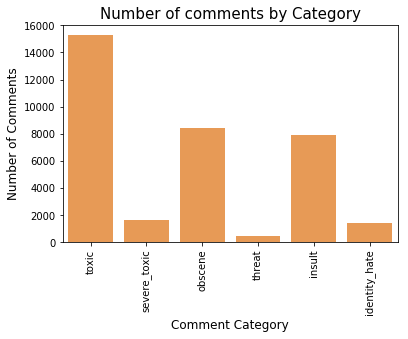

In [8]:
#Exploring the Training dataset more
#look by each category
comment_count=train.iloc[:,2:].sum()
sns.barplot(comment_count.index, comment_count.values, alpha=0.8, color=color[1])
plt.ylabel('Number of Comments', fontsize=12)
plt.xlabel('Comment Category', fontsize=12)
plt.title('Number of comments by Category', fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

In [9]:
comment_count.values

array([15294,  1595,  8449,   478,  7877,  1405])

#### Key observations from the above graph
<p>
1. Most of the comments are marked as toxic comments
</p>
<p>
2. Comments in each category are not classified exclusiviely as the count of comments in each category exceed the total number of comments. This means that one comment has been categorized in one or more categories.
</p>

In [10]:
#checking the comments that have not been categorized at all
comment_count=train.iloc[:,2:].sum()
rowsums=train.iloc[:,2:].sum(axis=1)
tagged_com=comment_count.sum()

In [11]:
train['clean_comments']=(rowsums==0)
#count number of clean entries
train['clean_comments'].sum()

143346

In [12]:
#making a graph of totat clean comments vs non-clean comments
clean = train['clean_comments'].sum()
comment_count=train.iloc[:,2:].sum()
clean
type(clean)

numpy.int64

In [13]:
tagged_com
type(tagged_com)

numpy.int64

<BarContainer object of 2 artists>

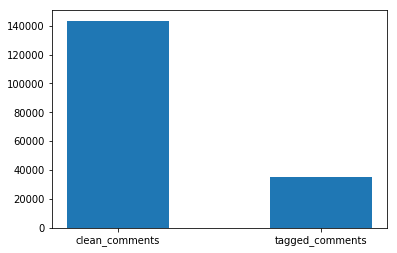

In [14]:
fig, ax  = plt2.subplots()
ax.bar([1, 2], [clean,tagged_com], width=0.5,
tick_label=['clean_comments', 'tagged_comments'], align='center')

In [15]:
comm_count1=rowsums.value_counts()
comment_count=train.iloc[:,2:].sum()
comment_count
train.head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean_comments
0,0000997932d777bf,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,0,0,0,0,0,True
1,000103f0d9cfb60f,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,0,0,0,0,0,True
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,0,0,0,0,0,True
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0,0,0,0,0,0,True
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember what page that's on?",0,0,0,0,0,0,True


The number of clean comments are much more than the comments that are tagged as bad. This means that we have an imbalanced dataset.


In [16]:
# Plotting another graphs which shows the count of how many times each comment is tagged
rowsums=train.iloc[:,2:7].sum(axis=1)
comm_count1=rowsums.value_counts()
comm_count1

0    143400
1      6473
3      4647
2      3510
4      1446
5        95
dtype: int64

In [17]:
comm_count2=comm_count1.iloc[1:6]
comm_count2

1    6473
3    4647
2    3510
4    1446
5      95
dtype: int64

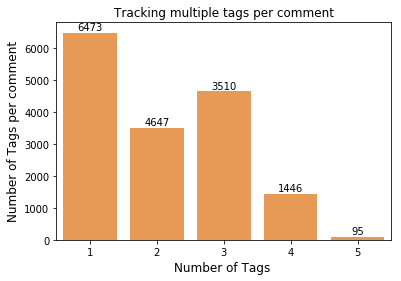

In [18]:
#plot
#plt.figure(figsize=(8,4))
ax = sns.barplot(comm_count2.index, comm_count2.values, alpha=0.8,color=color[1])
plt.title('Tracking multiple tags per comment')
plt.ylabel('Number of Tags per comment', fontsize=12)
plt.xlabel('Number of Tags ', fontsize=12)

rects = ax.patches
labels = comm_count2.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

Most of the comments that are tagged have been tagged for more than one category.

### Analyze Comment Text

In [19]:
train.head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean_comments
0,0000997932d777bf,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,0,0,0,0,0,True
1,000103f0d9cfb60f,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,0,0,0,0,0,True
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,0,0,0,0,0,True
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0,0,0,0,0,0,True
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember what page that's on?",0,0,0,0,0,0,True


In [20]:
train = train.applymap(lambda x: 1 if x == True else x)
train = train.applymap(lambda x: 0 if x == False else x)

In [21]:
train.head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean_comments
0,0000997932d777bf,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,0,0,0,0,0,1
1,000103f0d9cfb60f,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,0,0,0,0,0,1
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,0,0,0,0,0,1
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0,0,0,0,0,0,1
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember what page that's on?",0,0,0,0,0,0,1


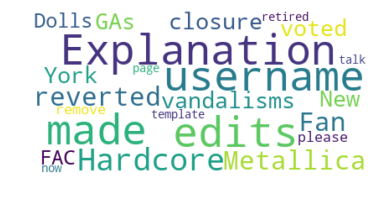

In [22]:
#Most common words in the comments (both clean and tagged comments)
# drawing a word cloud
# Start with one review:
text = train.comment_text[0]

wordcloud = WordCloud().generate(text)
# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=500, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [23]:
type(text)

str

In [24]:
?wordcloud

Above wordcloud does not give us much information as it is on imbalanced data. We need to run the wordlcoud on the comments which have been tagged.

In [25]:
comment_count=train.iloc[:,2:].sum()
train['total']=train.iloc[:,2:6].sum(axis=1)
#train=train.drop(['total_comments'], axis=1)
train.head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean_comments,total
0,0000997932d777bf,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,0,0,0,0,0,1,0
1,000103f0d9cfb60f,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,0,0,0,0,0,1,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,0,0,0,0,0,1,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0,0,0,0,0,0,1,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember what page that's on?",0,0,0,0,0,0,1,0


In [26]:
#subset for the tagged dataset only
train_tag= train[(train.total >0)]
train_tag.head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean_comments,total
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,0,3
12,0005c987bdfc9d4b,"Hey... what is it..\n@ | talk .\nWhat is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?\n\nAsk Sityush to clean up his behavior than issue me nonsensical warnings...",1,0,0,0,0,0,0,1
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming back! Tosser.",1,0,0,0,0,0,0,1
42,001810bf8c45bf5f,"You are gay or antisemmitian? \n\nArchangel WHite Tiger\n\nMeow! Greetingshhh!\n\nUh, there are two ways, why you do erased my comment about WW2, that holocaust was brutally slaying of Jews and not gays/Gypsys/Slavs/anyone...\n\n1 - If you are anti-semitian, than shave your head bald and go to the skinhead meetings!\n\n2 - If you doubt words of the Bible, that homosexuality is a deadly sin, make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals!\n\n3 - First and last warning, you fucking gay - I won't appreciate if any more nazi shwain would write in my page! I don't wish to talk to you anymore!\n\nBeware of the Dark Side!",1,0,1,0,1,1,0,2
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0,0,2


In [27]:
text = train_tag['comment_text']
text_1= str(text.values)
type(text_1)

str

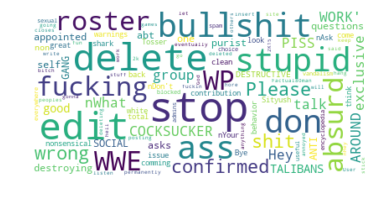

In [28]:
#text = train.comment_text[0]

wordcloud = WordCloud().generate(text_1)
# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=500, background_color="white").generate(text_1)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

The above word cloud shows the most frequent occurring words in the comments that are tagged as toxic. This word cloud is more meaningful than the previous one as we can see the words that are more used in bad comments.

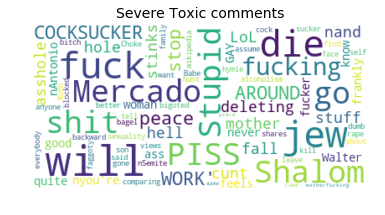

In [29]:
#word cloud for all the five categories
text_toxic=train[train.severe_toxic==1]
text_toxic_2=str(text_toxic.comment_text.values)
type(text_toxic_2)
wordcloud = WordCloud().generate(text_toxic_2)
# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=500, background_color="white").generate(text_toxic_2)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("Severe Toxic comments",fontsize =14)
plt.axis("off")
plt.show()

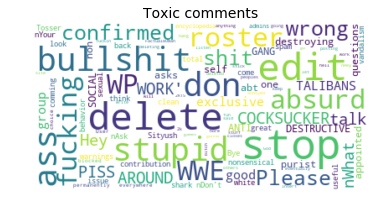

In [30]:
text_toxic=train[train.toxic==1]
text_toxic_2=str(text_toxic.comment_text.values)
type(text_toxic_2)
wordcloud = WordCloud().generate(text_toxic_2)
# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=500, background_color="white").generate(text_toxic_2)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("Toxic comments",fontsize =14)
plt.axis("off")
plt.show()

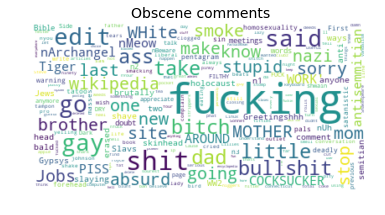

In [31]:
text_toxic=train[train.obscene==1]
text_toxic_2=str(text_toxic.comment_text.values)
type(text_toxic_2)
wordcloud = WordCloud().generate(text_toxic_2)
# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=500, background_color="white").generate(text_toxic_2)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("Obscene comments",fontsize =14)
plt.axis("off")
plt.show()

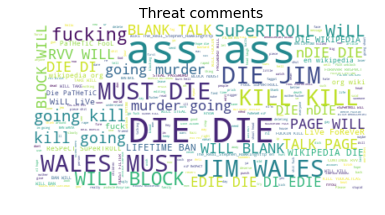

In [32]:
text_toxic=train[train.threat==1]
text_toxic_2=str(text_toxic.comment_text.values)
type(text_toxic_2)
wordcloud = WordCloud().generate(text_toxic_2)
# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=500, background_color="white").generate(text_toxic_2)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("Threat comments",fontsize =14)
plt.axis("off")
plt.show()

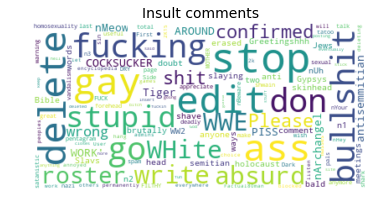

In [33]:
text_toxic=train[train.insult==1]
text_toxic_2=str(text_toxic.comment_text.values)
type(text_toxic_2)
wordcloud = WordCloud().generate(text_toxic_2)
# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=500, background_color="white").generate(text_toxic_2)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("Insult comments",fontsize =14)
plt.axis("off")
plt.show()

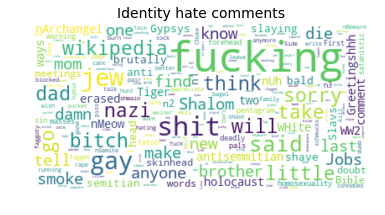

In [34]:
text_toxic=train[train.identity_hate==1]
text_toxic_2=str(text_toxic.comment_text.values)
type(text_toxic_2)
wordcloud = WordCloud().generate(text_toxic_2)
# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=500, background_color="white").generate(text_toxic_2)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("Identity hate comments",fontsize =14)
plt.axis("off")
plt.show()

In [35]:
text_1= text.values
type(text_1)

numpy.ndarray

### Data Cleaning

Before we can use the comment text for oru model, we need to ensure that the data is clean.

In [36]:
#Eliminating null comments
train = train[~(train.comment_text.isnull())]
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159571 entries, 0 to 159570
Data columns (total 10 columns):
id                159571 non-null object
comment_text      159571 non-null object
toxic             159571 non-null int64
severe_toxic      159571 non-null int64
obscene           159571 non-null int64
threat            159571 non-null int64
insult            159571 non-null int64
identity_hate     159571 non-null int64
clean_comments    159571 non-null int64
total             159571 non-null int64
dtypes: int64(8), object(2)
memory usage: 13.4+ MB


In [37]:
#drawing a word frequency graph
#counts = Counter(text_1)

#labels, values = zip(*counts.items())

# sort your values in descending order
#indSort = np.argsort(values)[::-1]

# rearrange your data
#labels = np.array(labels)[indSort]
#values = np.array(values)[indSort]

#indexes = np.arange(len(labels))

#bar_width = 0.35

#plt.bar(indexes, values)

# add labels
#plt.xticks(indexes + bar_width, labels)
#plt.show()



While trying to draw a word frequency graph, I noticed that there are few things in the data that need to be fixed.

<p>
(1) Removing the special characters like @,$ etc that have been used in the comments
</p>
<p>
(2) Removing extra spaces
</p>
<p>
(3) Removing repetitive words
</p>
<p>
(4) Removing the stop words
</p>

In [38]:
train["comment_text"]

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [39]:
all_train_comment = train.comment_text.values
all_train_comment

array(["Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",
       "D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)",
       "Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",
       ...,
       'Spitzer \n\nUmm, theres no actual article for prostitution ring.  - Crunch Captain.',
       'And it looks like it was actually you who put on the speedy to have the first version deleted now that I look at it.',
       '"\nAnd ... I really don\'t think you understand.  I came here and my idea was bad right away.  What kind of communit

In [40]:
train_comment = train.comment_text[:20000]
train_comment=str(train_comment)
test_comment = test.comment_text[20000:40000]
test_comment=str(train_comment)

In [41]:
# Removing the punctuations
stop_words = set(stopwords.words('english'))
punctuations = set(string.punctuation)

In [42]:
train_comment_tokens=word_tokenize(train_comment.lower())

In [43]:
#train_comment_p=[w for w in train_comment_tokens if not w in punctuations]
#train_comment_p

In [44]:
# removing the stop words
#Referred https://github.com/Mernegar/Toxic-Comment/blob/master/Warngling%20and%20Normalization/Text%20Pre-Processing.ipynb
nlp = spacy.load('en', parse = False, tag=False, entity=False)
stop_words = nltk.corpus.stopwords.words('english')
stop_words.remove('no')
stop_words.remove('not')

def strip_tags(text):
    text = text.lower()
    text = re.sub(r"http\s?:\s?\S+", "", text)
    text = re.sub(r"(^[@|#]\[w|d]+)", "" , text)
    text = re.sub(r"e\s?-\s?mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"j/k", "jk", text)
    text = re.sub(r"http\s?;\s?\S+", "", text)
    return text

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD' , text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def expand_contractions(text):
    return contractions.fix(text)

def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

def remove_special_characters(text , remove_digits = False):
    pattern = r'[^a-zA-Z0-9\s]' if not remove_digits else r'[^a-zA-Z\s]'
    text = re.sub(pattern , "" , text)
    return text

def remove_stopwords(text, is_lower_case=False, stopwords=None):
    if not stopwords:
        stopwords = nltk.corpus.stopwords.words('english')
    tokens = nltk.word_tokenize(text)
    tokens = [token.strip() for token in tokens]
    
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopwords]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopwords]
    
    filtered_text = " ".join(filtered_tokens)
    return filtered_text

As we can see above, there are lot of extra characters that we need to eliminate before we use the text for our model.

In [45]:
def pre_process_document(document):
    
    # lower case
    document = document.lower()
    
    # remove extra newlines
    document = document.translate(document.maketrans("\n\t\r", "   "))
    
    # strip tags
    document = strip_tags(document)
    
    # remove accented characters
    document = remove_accented_chars(document)
    
    # expand contractions
    document = expand_contractions(document)
    
    # text lemmatizatin
    document = lemmatize_text(document)
    
    # remove special characters
    document = remove_special_characters(document , remove_digits= True)
    
    # remove stopwords
    document = remove_stopwords(document , is_lower_case= True , stopwords= stop_words)
    
    #remove extra whitespace
    document = re.sub(' +', ' ' , document)
    
    document = document.strip()
    
    return document


pre_process_corpus = np.vectorize(pre_process_document)

In [46]:
%%time

norm_train_reviews = pre_process_corpus(train_comment)
#norm_test_reviews = pre_process_corpus(test_comment)

CPU times: user 2.64 s, sys: 134 ms, total: 2.77 s
Wall time: 2.77 s


In [47]:
norm_test_reviews = pre_process_corpus(test_comment)

In [48]:
type(norm_train_reviews)

numpy.ndarray

### Feature Engineering

In this section I am going to explore the commment text in detail. I am going to do this in two ways:

(1) Looking at the comment as a whole - counting the words in each comment, phrases
(2) Vectorizing all of the text

##### Analyzing the whole comment

In [49]:
train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean_comments,total
0,0000997932d777bf,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,0,0,0,0,0,1,0
1,000103f0d9cfb60f,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,0,0,0,0,0,1,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,0,0,0,0,0,1,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0,0,0,0,0,0,1,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember what page that's on?",0,0,0,0,0,0,1,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the tools well. · talk """,0,0,0,0,0,0,1,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,0,3
7,00031b1e95af7921,"Your vandalism to the Matt Shirvington article has been reverted. Please don't do it again, or you will be banned.",0,0,0,0,0,0,1,0
8,00037261f536c51d,"Sorry if the word 'nonsense' was offensive to you. Anyway, I'm not intending to write anything in the article(wow they would jump on me for vandalism), I'm merely requesting that it be more encyclopedic so one can use it for school as a reference. I have been to the selective breeding page but it's almost a stub. It points to 'animal breeding' which is a short messy article that gives you no info. There must be someone around with expertise in eugenics? 93.161.107.169",0,0,0,0,0,0,1,0
9,00040093b2687caa,alignment on this subject and which are contrary to those of DuLithgow,0,0,0,0,0,0,1,0


From the example below, we can notice that a comment that was typed in capital has been classfied as toxic, severe toxic,obscene and adult.
<p>
This indicated that comments have punctuations (like 4 excalamation marks) or a string of special charatcerS(intending to write abusive words)
</p>
<p>
We can look at below features in the comment:
</p>
<p>
Word level feaures
</p>
<p>
(1) Total number of words in the comment
</p>
<p>
(2) Total number of unique words in the comment
</p>
<p>
(3) Total articles in the comment
</p>
<p>
(4) Total number of stop words in the comment
</p>

<p>
Character level features
</p>
<p>
(1) Total number of characters in the comment
</p>
<p>
(2) Total number of unique characters in the comment
 </p>
 <p>
(3) Total number of special characters like '! @ $' in the comments
</p>


In [50]:
#Word level features

train['total_length'] = train['comment_text'].apply(len)
train['num_words'] = train['comment_text'].apply(lambda comment: len(comment.split()))
train['num_unique_words'] = train['comment_text'].apply(
    lambda comment: len(set(w for w in comment.split())))
train['words_vs_unique'] = train['num_unique_words'] / train['num_words']
train['count_sent']=train["comment_text"].apply(lambda x: len(re.findall("\n",str(x)))+1)
train["count_words_upper"] = train["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
train["count_words_lower"] = train["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.islower()]))
train["mean_word_len"] = train["comment_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [51]:
train.head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean_comments,total,total_length,num_words,num_unique_words,words_vs_unique,count_sent,count_words_upper,count_words_lower,mean_word_len
0,0000997932d777bf,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,0,0,0,0,0,1,0,264,43,41,0.953488,2,2,29,5.162791
1,000103f0d9cfb60f,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,0,0,0,0,0,1,0,112,17,17,1.000000,1,1,8,5.588235
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,0,0,0,0,0,1,0,233,42,39,0.928571,1,0,38,4.571429
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0,0,0,0,0,0,1,0,622,113,82,0.725664,5,5,100,4.486726
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember what page that's on?",0,0,0,0,0,0,1,0,67,13,13,1.000000,1,0,11,4.230769


In [52]:
#Character level features

#df['count_word']=df["comment_text"].apply(lambda x: len(str(x).split()))
#Unique word count
#df['count_unique_word']=df["comment_text"].apply(lambda x: len(set(str(x).split())))


train['count_letters']=train["comment_text"].apply(lambda x: len(str(x)))
train['unique_letters']=train["comment_text"].apply(lambda x: len(set(str(x))))
train["count_punctuations_1"] =train["comment_text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
train['num_separators'] = train['comment_text'].apply(
    lambda comment: sum(comment.count(w) for w in '.,;:'))
train['num_exclamation_marks'] = train['comment_text'].apply(lambda comment: comment.count('!'))
train['num_question_marks'] = train['comment_text'].apply(lambda comment: comment.count('?'))
train['num_symbols'] = train['comment_text'].apply(
    lambda comment: sum(comment.count(w) for w in '*&$%'))

In [53]:
#train = train.drop(['count_punctuations_1'], axis=1)

In [54]:
train.head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean_comments,total,...,count_words_upper,count_words_lower,mean_word_len,count_letters,unique_letters,count_punctuations_1,num_separators,num_exclamation_marks,num_question_marks,num_symbols
0,0000997932d777bf,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,0,0,0,0,0,1,0,...,2,29,5.162791,264,49,10,6,0,1,0
1,000103f0d9cfb60f,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,0,0,0,0,0,1,0,...,1,8,5.588235,112,39,12,5,1,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,0,0,0,0,0,1,0,...,0,38,4.571429,233,29,6,4,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0,0,0,0,0,0,1,0,...,5,100,4.486726,622,38,21,6,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember what page that's on?",0,0,0,0,0,0,1,0,...,0,11,4.230769,67,24,5,3,0,1,0


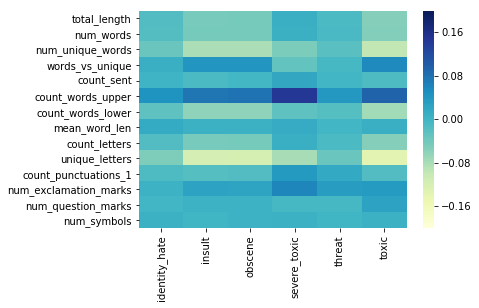

In [55]:
features = ('total_length','num_words','num_unique_words','words_vs_unique','count_sent','count_words_upper',
            'count_words_lower','mean_word_len','count_letters','unique_letters','count_punctuations_1',
            'num_exclamation_marks','num_question_marks','num_symbols')
columns = ('toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate')

rows = [{c:train[f].corr(train[c]) for c in columns} for f in features]
train_corr = pd.DataFrame(rows, index=features)
ax = sns.heatmap(train_corr, vmin=-0.2, vmax=0.2, center=0.0, cmap="YlGnBu")

From the above heatmap we can notice that below features are working for all the classes:
<p>
(1) total number of words in upper case
</p>
<p>
(2) Proportion of unique words to total words in the comment
</p>
<p>
(3) Mean length of each word
</p>
<p>
(4) Count of punctuations in the comment
</p>
<p>
(5) number of exclamation marks
</p>
<p>
(6) Count of sentences
</p>

One interesting thing to note here is that if the letters are in upper case then it is highly likely for a comment to be severe
toxic

#### Using the vectorizer approach here

In [56]:
train_copy=train

In [57]:
# remove '\\n'
train_copy['comment_text'] = train_copy['comment_text'].map(lambda x: re.sub('\\n',' ',str(x)))
    
# remove any text starting with User... 
train_copy['comment_text'] = train_copy['comment_text'].map(lambda x: re.sub("\[\[User.*",'',str(x)))
    
# remove IP addresses or user IDs
train_copy['comment_text'] = train_copy['comment_text'].map(lambda x: re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}",'',str(x)))
    
#remove http links in the text
train_copy['comment_text'] = train_copy['comment_text'].map(lambda x: re.sub("(http://.*?\s)|(http://.*)",'',str(x)))


In [58]:
train_copy.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean_comments,total,...,count_words_upper,count_words_lower,mean_word_len,count_letters,unique_letters,count_punctuations_1,num_separators,num_exclamation_marks,num_question_marks,num_symbols
0,0000997932d777bf,"Explanation Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.",0,0,0,0,0,0,1,0,...,2,29,5.162791,264,49,10,6,0,1,0
1,000103f0d9cfb60f,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,0,0,0,0,0,1,0,...,1,8,5.588235,112,39,12,5,1,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,0,0,0,0,0,1,0,...,0,38,4.571429,233,29,6,4,0,0,0
3,0001b41b1c6bb37e,""" More I can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know. There appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0,0,0,0,0,0,1,0,...,5,100,4.486726,622,38,21,6,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember what page that's on?",0,0,0,0,0,0,1,0,...,0,11,4.230769,67,24,5,3,0,1,0
5,00025465d4725e87,""" Congratulations from me as well, use the tools well. · talk """,0,0,0,0,0,0,1,0,...,0,9,3.923077,65,24,4,2,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,0,3,...,8,0,4.625000,44,18,0,0,0,0,0
7,00031b1e95af7921,"Your vandalism to the Matt Shirvington article has been reverted. Please don't do it again, or you will be banned.",0,0,0,0,0,0,1,0,...,0,16,4.750000,115,27,4,3,0,0,0
8,00037261f536c51d,"Sorry if the word 'nonsense' was offensive to you. Anyway, I'm not intending to write anything in the article(wow they would jump on me for vandalism), I'm merely requesting that it be more encyclopedic so one can use it for school as a reference. I have been to the selective breeding page but it's almost a stub. It points to 'animal breeding' which is a short messy article that gives you no info. There must be someone around with expertise in eugenics?",0,0,0,0,0,0,1,0,...,1,75,4.698795,472,41,19,9,0,1,0
9,00040093b2687caa,alignment on this subject and which are contrary to those of DuLithgow,0,0,0,0,0,0,1,0,...,0,11,4.916667,70,23,0,0,0,0,0


In [59]:
#Using the TF -IDF Vectorizer

In [60]:
train_copy['total']=train_copy.iloc[:,2:6].sum(axis=1)

In [61]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

In [62]:
def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

In [63]:
def top_feats_by_class(Xtr, y, features, min_tfidf=0.1, top_n=25):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

In [64]:
uni_tfidf = TfidfVectorizer(max_features=30000, 
            strip_accents='unicode', analyzer='word',ngram_range=(1,1),
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

uni_tfidf_m = uni_tfidf.fit_transform(train_copy.comment_text)

uni_tfidf_m = uni_tfidf_m.toarray()

features = uni_tfidf.get_feature_names()


In [65]:
uni_tfidf_m

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [66]:
uni_tfidf_m_s=uni_tfidf_m[:20]

In [67]:
tv = pd.DataFrame(np.round(uni_tfidf_m_s, 2), columns=features)

Text(0.5,1,'Top Unigrams')

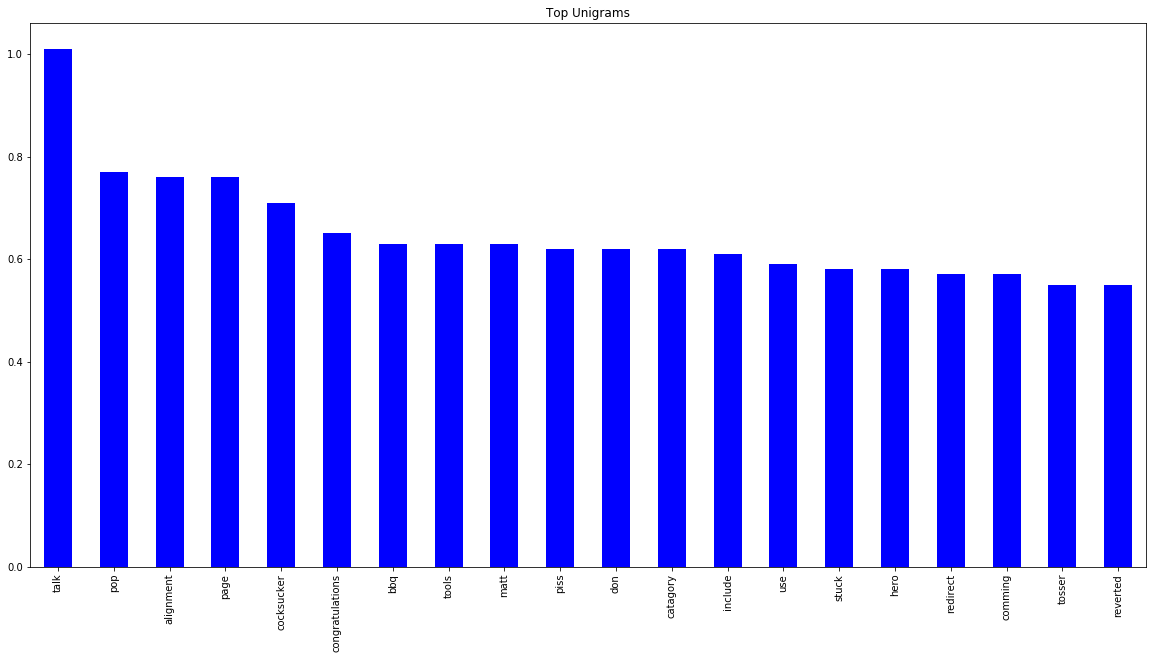

In [68]:
plt.figure(figsize=(20, 10))
_ = tv.sum(axis = 0).sort_values(ascending=False)[:20].plot(kind = 'bar' , color = 'blue')
plt.title("Top Unigrams")

Above graph is not very helpful because they don't help in identifying the words that are tagged as toxic. Let us try looking the words in the comments 
that were tagged.

In [69]:
#train_tag

In [70]:
uni_tfidf = TfidfVectorizer(max_features=30000, 
            strip_accents='unicode', analyzer='word',ngram_range=(1,1),
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

uni_tfidf_m = uni_tfidf.fit_transform(train_tag.comment_text)

uni_tfidf_m = uni_tfidf_m.toarray()

features = uni_tfidf.get_feature_names()


In [71]:
uni_tfidf_m_s=uni_tfidf_m[:20]
tv = pd.DataFrame(np.round(uni_tfidf_m_s, 2), columns=features)

Text(0.5,1,'Top Unigrams for tagged comments')

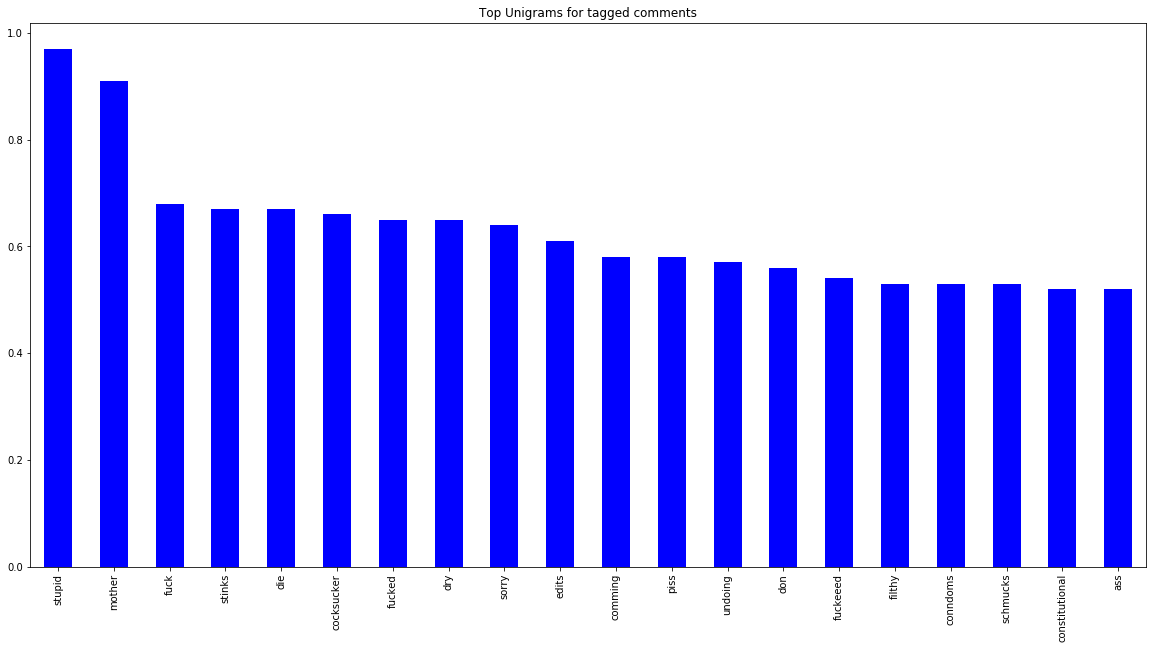

In [72]:
plt.figure(figsize=(20, 10))
_ = tv.sum(axis = 0).sort_values(ascending=False)[:20].plot(kind = 'bar' , color = 'blue')
plt.title("Top Unigrams for tagged comments")

In [73]:
# Also checking if we can use multiple words


In [74]:
bi_tfidf = TfidfVectorizer(max_features=30000, 
            strip_accents='unicode', analyzer='word',ngram_range=(2,2),
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

bi_tfidf_m = bi_tfidf.fit_transform(train_tag.comment_text)

bi_tfidf_m = bi_tfidf_m.toarray()

features = bi_tfidf.get_feature_names()


In [75]:
bi_tfidf_m_s=uni_tfidf_m[:20]
tv = pd.DataFrame(np.round(bi_tfidf_m_s, 2), columns=features)

Text(0.5,1,'Top Bigrams for tagged comments')

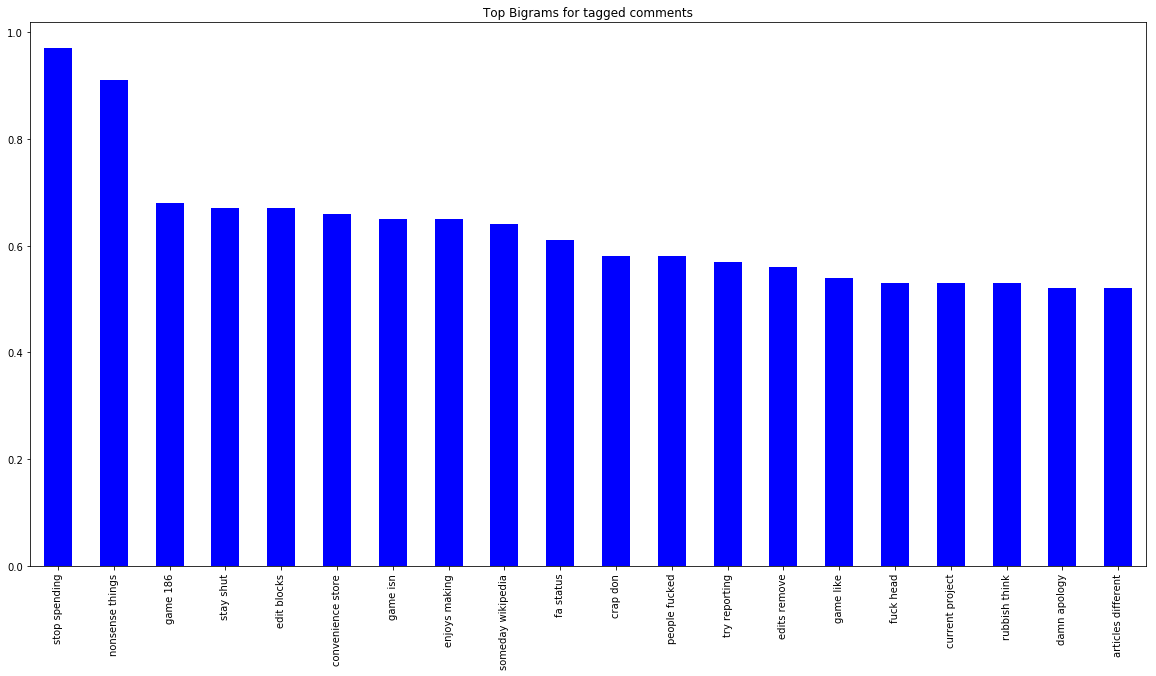

In [76]:
plt.figure(figsize=(20, 10))
_ = tv.sum(axis = 0).sort_values(ascending=False)[:20].plot(kind = 'bar' , color = 'blue')
plt.title("Top Bigrams for tagged comments")

In [77]:
#Creating unigrams here
#uni_tfidf = TfidfVectorizer(max_features=30000, 
            #strip_accents='unicode', analyzer='word',ngram_range=(1,1),
            #use_idf=1,smooth_idf=1,sublinear_tf=1,
            #stop_words = 'english')

#uni_tfidf_m=uni_tfidf.fit_transform(train_copy.comment_text)
#uni_tfidf_m=uni_tfidf_m.toarray()
#features = uni_tfidf.get_feature_names()
#train_bigrams =  uni_tfidf.transform(train_copy.iloc[:train.shape[0]])
#test_bigrams = tfv.transform(clean_corpus.iloc[train.shape[0]:])
#get top n for bigrams
#train_bigrams

#features

In [78]:
#uni_tfidf_m

### Building the Model

In [79]:
test.head()

,id,comment_text
0,00001cee341fdb12,"Yo bitch Ja Rule is more succesful then you'll ever be whats up with you and hating you sad mofuckas...i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me. Ja rule is about pride in da music man. dont diss that shit on him. and nothin is wrong bein like tupac he was a brother too...fuckin white boys get things right next time.,"
1,0000247867823ef7,"== From RfC == \n\n The title is fine as it is, IMO."
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lapland — / """
3,00017563c3f7919a,":If you have a look back at the source, the information I updated was the correct form. I can only guess the source hadn't updated. I shall update the information once again but thank you for your message."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [80]:
#checking if train has null comments
test = test[~(test['comment_text'].isnull())]

In [81]:
test_labels

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1
5,0001ea8717f6de06,0,0,0,0,0,0
6,00024115d4cbde0f,-1,-1,-1,-1,-1,-1
7,000247e83dcc1211,0,0,0,0,0,0
8,00025358d4737918,-1,-1,-1,-1,-1,-1
9,00026d1092fe71cc,-1,-1,-1,-1,-1,-1


In [82]:
x = train.comment_text
test_X = test.comment_text

In [83]:
y = train.iloc[:, 2:8]  

In [84]:
vect = TfidfVectorizer(max_features=30000, 
            strip_accents='unicode', analyzer='word',ngram_range=(1,1),
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')
vect

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=30000,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=1, stop_words='english', strip_accents='unicode',
                sublinear_tf=1, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=1, vocabulary=None)

In [85]:
# Training and test split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state=13)

In [86]:
#vectorize 
vect.fit(X_train)
X_train_word_features = vect.transform(X_train)

#transform the test features to sparse matrix
test_features = vect.transform(X_test)

Accuracy score for class toxic is 0.9589835178269303
Precision for class toxic is 0.8670078786242417
Recall for class toxic is 0.6784492510458027
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     28927
           1       0.85      0.68      0.75      2988

    accuracy                           0.96     31915
   macro avg       0.91      0.83      0.87     31915
weighted avg       0.96      0.96      0.96     31915

Accuracy score for class severe_toxic is 0.9901923827175312
Precision for class severe_toxic is 0.5326572101175643
Recall for class severe_toxic is 0.28636975846278173
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     31612
           1       0.53      0.30      0.38       303

    accuracy                           0.99     31915
   macro avg       0.76      0.65      0.69     31915
weighted avg       0.99      0.99      0.99     31915

Accuracy score for class obscene

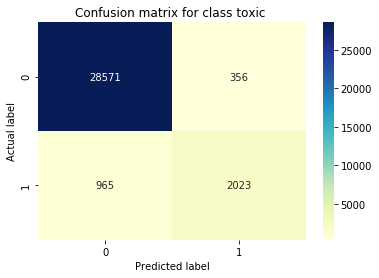

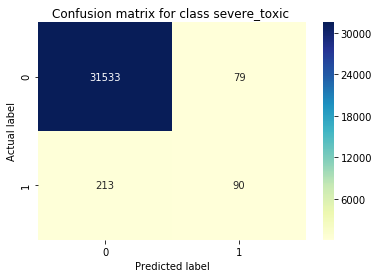

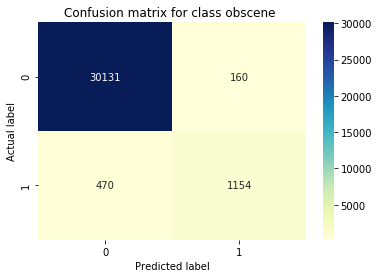

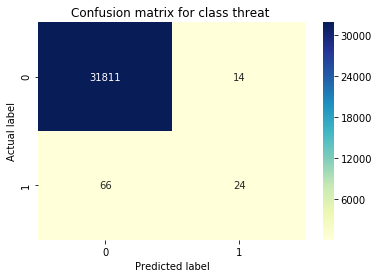

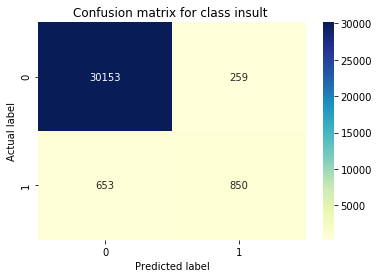

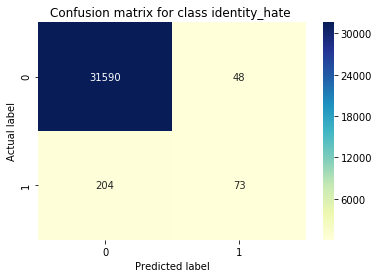

In [87]:
class_names = ['toxic','severe_toxic','obscene', 'threat', 'insult', 'identity_hate']

losses = []
auc = []
prec = []
recal = []
accur = []

for class_name in class_names:
    #call the labels one column at a time so we can run the classifier on them
    train_target = y_train[class_name]
    test_target = y_test[class_name]
    classifier = LogisticRegression(solver='sag', C=10)

    #cv_loss = np.mean(cross_val_score(classifier, X_train_word_features, train_target, cv=5, scoring='neg_log_loss'))
    #losses.append(cv_loss)
    #print('CV Log_loss score for class {} is {}'.format(class_name, cv_loss))
    
    #Accuracy Score
    accuracy_score = np.mean(cross_val_score(classifier, X_train_word_features, train_target, cv=5, scoring='accuracy'))
    precision_score = np.mean(cross_val_score(classifier, X_train_word_features, train_target, cv=5, scoring='precision'))
    recall_score = np.mean(cross_val_score(classifier, X_train_word_features, train_target, cv=5, scoring='recall'))
    print('Accuracy score for class {} is {}'.format(class_name, accuracy_score))
    print('Precision for class {} is {}'.format(class_name, precision_score))
    print('Recall for class {} is {}'.format(class_name, recall_score))
    
    accur.append(accuracy_score)
    prec.append(precision_score)
    recal.append(recall_score)
          
    classifier.fit(X_train_word_features, train_target)
    y_pred = classifier.predict(test_features)
    y_pred_prob = classifier.predict_proba(test_features)[:, 1]
    
    #Confusion matrix
    
    cnf_matrix = metrics.confusion_matrix(test_target, y_pred)
    class_names=[0,1] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
    #ax.xaxis.set_label_position("top")
    #plt.tight_layout()
    plt.title('Confusion matrix for class {} '.format(class_name))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    

    auc_score = metrics.roc_auc_score(test_target, y_pred_prob)
    auc.append(auc_score)
    #print("CV ROC_AUC score {}\n".format(auc_score))
    
    #print(confusion_matrix(test_target, y_pred))
    print(classification_report(test_target, y_pred))

#print('Total average CV Log_loss score is {}'.format(np.mean(losses)))
print('Total accuracy score is {}'.format(np.mean(accur)))
print('Total precision is {}'.format(np.mean(prec)))
print('Total recall is {}'.format(np.mean(recal)))
print('Total average CV ROC_AUC score is {}'.format(np.mean(auc)))


In [88]:
# Trying the tfidf with bigrams and see if it can improve the model
vect = TfidfVectorizer(max_features=30000, 
            strip_accents='unicode', analyzer='word',ngram_range=(2,2),
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')
vect

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=30000,
                min_df=1, ngram_range=(2, 2), norm='l2', preprocessor=None,
                smooth_idf=1, stop_words='english', strip_accents='unicode',
                sublinear_tf=1, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=1, vocabulary=None)

In [89]:
# Training and test split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state=13)
#vectorize 
vect.fit(X_train)
X_train_word_features = vect.transform(X_train)

#transform the test features to sparse matrix
test_features = vect.transform(X_test)

Accuracy score for class toxic is 0.9173873445332742
Precision for class toxic is 0.6832037577019563
Recall for class toxic is 0.26702422948277454
              precision    recall  f1-score   support

           0       0.93      0.99      0.96     28927
           1       0.65      0.26      0.37      2988

    accuracy                           0.92     31915
   macro avg       0.79      0.62      0.66     31915
weighted avg       0.90      0.92      0.90     31915

Accuracy score for class severe_toxic is 0.9899965549463824
Precision for class severe_toxic is 0.5225668498168499
Recall for class severe_toxic is 0.14783155248271526
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     31612
           1       0.47      0.16      0.23       303

    accuracy                           0.99     31915
   macro avg       0.73      0.58      0.61     31915
weighted avg       0.99      0.99      0.99     31915

Accuracy score for class obscen

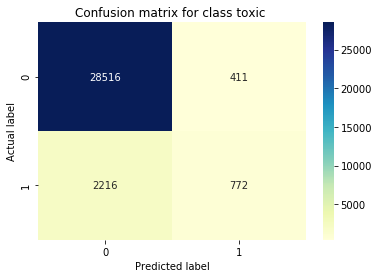

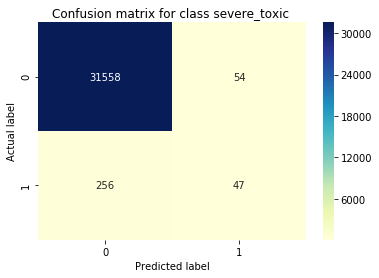

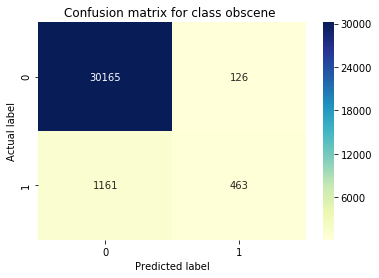

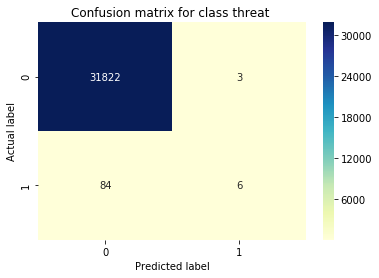

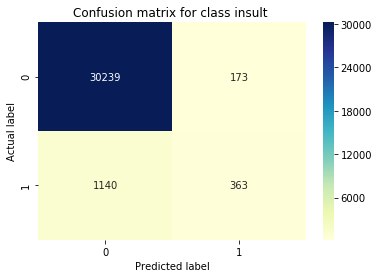

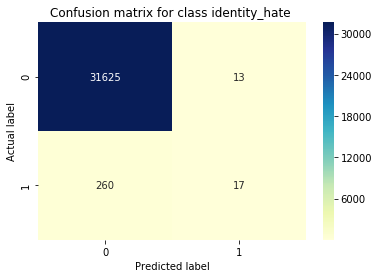

In [93]:
class_names = ['toxic','severe_toxic','obscene', 'threat', 'insult', 'identity_hate']

losses = []
auc = []
prec = []
recal = []
accur = []

for class_name in class_names:
    #call the labels one column at a time so we can run the classifier on them
    train_target = y_train[class_name]
    test_target = y_test[class_name]
    classifier = LogisticRegression(solver='sag', C=10)

    #cv_loss = np.mean(cross_val_score(classifier, X_train_word_features, train_target, cv=5, scoring='neg_log_loss'))
    #losses.append(cv_loss)
    #print('CV Log_loss score for class {} is {}'.format(class_name, cv_loss))
    
    #Accuracy Score
    accuracy_score = np.mean(cross_val_score(classifier, X_train_word_features, train_target, cv=5, scoring='accuracy'))
    precision_score = np.mean(cross_val_score(classifier, X_train_word_features, train_target, cv=5, scoring='precision'))
    recall_score = np.mean(cross_val_score(classifier, X_train_word_features, train_target, cv=5, scoring='recall'))
    print('Accuracy score for class {} is {}'.format(class_name, accuracy_score))
    print('Precision for class {} is {}'.format(class_name, precision_score))
    print('Recall for class {} is {}'.format(class_name, recall_score))
    
    accur.append(accuracy_score)
    prec.append(precision_score)
    recal.append(recall_score)
          
    classifier.fit(X_train_word_features, train_target)
    y_pred = classifier.predict(test_features)
    y_pred_prob = classifier.predict_proba(test_features)[:, 1]
    
    #Confusion matrix
    
    cnf_matrix = metrics.confusion_matrix(test_target, y_pred)
    class_names=[0,1] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
    #ax.xaxis.set_label_position("top")
    #plt.tight_layout()
    plt.title('Confusion matrix for class {} '.format(class_name))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    

    auc_score = metrics.roc_auc_score(test_target, y_pred_prob)
    auc.append(auc_score)
    #print("CV ROC_AUC score {}\n".format(auc_score))
    
    #print(confusion_matrix(test_target, y_pred))
    print(classification_report(test_target, y_pred))

#print('Total average CV Log_loss score is {}'.format(np.mean(losses)))
print('Total accuracy score is {}'.format(np.mean(accur)))
print('Total precision is {}'.format(np.mean(prec)))
print('Total recall is {}'.format(np.mean(recal)))
print('Total average CV ROC_AUC score is {}'.format(np.mean(auc)))


##### By using bigrams, the precision of our model decreased from 72% to 65%

In [90]:
# Trying Random Forest as it works well with imabalanced dataset
vect = TfidfVectorizer(max_features=30000, 
            strip_accents='unicode', analyzer='word',ngram_range=(2,2),
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')
vect

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=30000,
                min_df=1, ngram_range=(2, 2), norm='l2', preprocessor=None,
                smooth_idf=1, stop_words='english', strip_accents='unicode',
                sublinear_tf=1, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=1, vocabulary=None)

In [91]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state=13)
#vectorize 
vect.fit(X_train)
X_train_word_features = vect.transform(X_train)

#transform the test features to sparse matrix
test_features = vect.transform(X_test)

Accuracy score for class toxic is 0.9104781629172407
Precision for class toxic is 0.5801162610014355
Recall for class toxic is 0.25873547734586433
              precision    recall  f1-score   support

           0       0.93      0.98      0.95     28927
           1       0.56      0.24      0.33      2988

    accuracy                           0.91     31915
   macro avg       0.74      0.61      0.64     31915
weighted avg       0.89      0.91      0.89     31915

Accuracy score for class severe_toxic is 0.9888450317844558
Precision for class severe_toxic is 0.3669766542980829
Recall for class severe_toxic is 0.13934033701475562
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     31612
           1       0.40      0.14      0.21       303

    accuracy                           0.99     31915
   macro avg       0.70      0.57      0.60     31915
weighted avg       0.99      0.99      0.99     31915

Accuracy score for class obscen

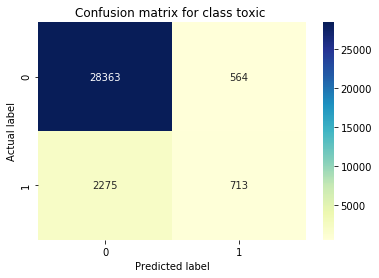

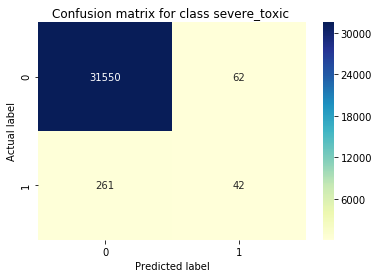

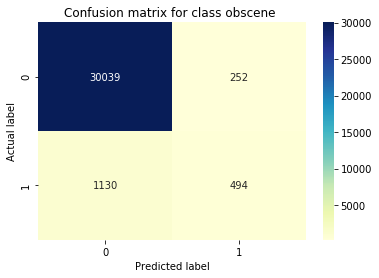

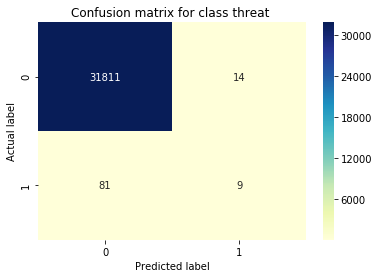

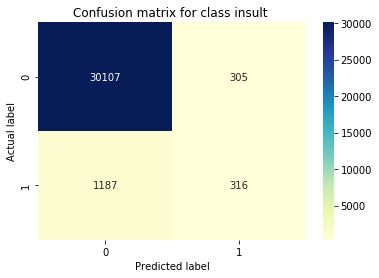

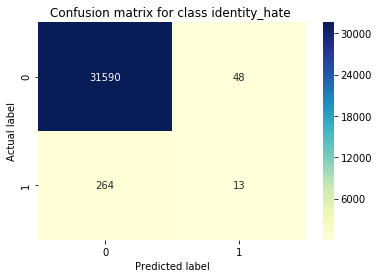

In [92]:
class_names = ['toxic','severe_toxic','obscene', 'threat', 'insult', 'identity_hate']

losses = []
auc = []
prec = []
recal = []
accur = []

for class_name in class_names:
    #call the labels one column at a time so we can run the classifier on them
    train_target = y_train[class_name]
    test_target = y_test[class_name]
    classifier = RandomForestClassifier(n_jobs=2, random_state=0,n_estimators=2)

    #cv_loss = np.mean(cross_val_score(classifier, X_train_word_features, train_target, cv=5, scoring='neg_log_loss'))
    #losses.append(cv_loss)
    #print('CV Log_loss score for class {} is {}'.format(class_name, cv_loss))
    
    #Accuracy Score
    accuracy_score = np.mean(cross_val_score(classifier, X_train_word_features, train_target, cv=5, scoring='accuracy'))
    precision_score = np.mean(cross_val_score(classifier, X_train_word_features, train_target, cv=5, scoring='precision'))
    recall_score = np.mean(cross_val_score(classifier, X_train_word_features, train_target, cv=5, scoring='recall'))
    print('Accuracy score for class {} is {}'.format(class_name, accuracy_score))
    print('Precision for class {} is {}'.format(class_name, precision_score))
    print('Recall for class {} is {}'.format(class_name, recall_score))
    
    accur.append(accuracy_score)
    prec.append(precision_score)
    recal.append(recall_score)
          
    classifier.fit(X_train_word_features, train_target)
    y_pred = classifier.predict(test_features)
    y_pred_prob = classifier.predict_proba(test_features)[:, 1]
    
    #Confusion matrix
    
    cnf_matrix = metrics.confusion_matrix(test_target, y_pred)
    class_names=[0,1] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
    #ax.xaxis.set_label_position("top")
    #plt.tight_layout()
    plt.title('Confusion matrix for class {} '.format(class_name))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    

    auc_score = metrics.roc_auc_score(test_target, y_pred_prob)
    auc.append(auc_score)
    #print("CV ROC_AUC score {}\n".format(auc_score))
    
    #print(confusion_matrix(test_target, y_pred))
    print(classification_report(test_target, y_pred))

#print('Total average CV Log_loss score is {}'.format(np.mean(losses)))
print('Total accuracy score is {}'.format(np.mean(accur)))
print('Total precision is {}'.format(np.mean(prec)))
print('Total recall is {}'.format(np.mean(recal)))
print('Total average CV ROC_AUC score is {}'.format(np.mean(auc)))

While we analyzed the data, we noticed that the dataset was imbalanced. The number of clean comments was much higher 
than the number of tagged comments.
<p>
There are three approaches that we can take to deal with imbalanced dataset
</p>
<p>
(1) undersample the majority class
</p>
<p>
(2) Oversample the minority class
</p>
<p>
(3) Take a weighted sample
</p>

In this section, we are goign to try the second approach using SMOTE.

Reference :  https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/

There are systematic algorithms that you can use to generate synthetic samples and over sample the minority class. The most popular of such algorithms is called SMOTE or the Synthetic Minority Over-sampling Technique.

As its name suggests, SMOTE is an oversampling method. It works by creating synthetic samples from the minor class instead of creating copies. The algorithm selects two or more similar instances (using a distance measure) and perturbing an instance one attribute at a time by a random amount within the difference to the neighboring instances.

In [93]:
vect = TfidfVectorizer(max_features=30000, 
            strip_accents='unicode', analyzer='word',ngram_range=(1,1),
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')
vect

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=30000,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=1, stop_words='english', strip_accents='unicode',
                sublinear_tf=1, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=1, vocabulary=None)

In [94]:
# Training and test split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state=13)
#vectorize 
vect.fit(X_train)
X_train_word_features = vect.transform(X_train)

#transform the test features to sparse matrix
test_features = vect.transform(X_test)
print(X_train_word_features)

  (0, 19408)	0.17031814508388768
  (0, 18942)	0.3738183971641717
  (0, 12258)	0.33908716267625777
  (0, 11938)	0.4124000339293192
  (0, 9003)	0.24193675056156055
  (0, 4495)	0.4425101579719499
  (0, 1063)	0.3189118074168781
  (0, 948)	0.4360553536301419
  (1, 29464)	0.32534451977076395
  (1, 28275)	0.0716540123503452
  (1, 26863)	0.19629274438556082
  (1, 26643)	0.31017788208681096
  (1, 24678)	0.10903189813862665
  (1, 23864)	0.10423159162836203
  (1, 22152)	0.10546019062838394
  (1, 20815)	0.12292579889153114
  (1, 18188)	0.11169764623875605
  (1, 15943)	0.058597524780629996
  (1, 15827)	0.3654647421489452
  (1, 15567)	0.11099602080392544
  (1, 15246)	0.12991878169051532
  (1, 14209)	0.09410637170323065
  (1, 13574)	0.13763285878363538
  (1, 13342)	0.14850267505815334
  (1, 11530)	0.1466789521831237
  :	:
  (127655, 16079)	0.10046374419925692
  (127655, 15466)	0.16929701371706035
  (127655, 14618)	0.17290131430238598
  (127655, 14444)	0.22135960469249966
  (127655, 14048)	0.094348385

In [96]:
class_names = ['toxic','severe_toxic','obscene', 'threat', 'insult', 'identity_hate']

losses = []
auc = []
prec = []
recal = []
accur = []

for class_name in class_names:
    #call the labels one column at a time so we can run the classifier on them
    train_target = y_train[class_name]
    test_target = y_test[class_name]
    classifier = LogisticRegression(solver='sag', C=10)
    smote_pipeline = make_pipeline_imb(SMOTE(sampling_strategy= .5) , classifier)
    smote_model = smote_pipeline.fit(X_train_word_features , train_target)
    smote_predict = smote_model.predict(test_features)

    #print (metrics.accuracy_score(test_target , smote_predict))

    #print (metrics.confusion_matrix(test_target , smote_predict))

    #print("F1 score: ", metrics.f1_score(y_test , smote_predict))

    print("Precision score: " , metrics.precision_score(test_target , smote_predict))

    print("Recall score: " , metrics.recall_score(test_target , smote_predict))
    #cv_loss = np.mean(cross_val_score(classifier, X_train_word_features, train_target, cv=5, scoring='neg_log_loss'))
    #losses.append(cv_loss)
    #print('CV Log_loss score for class {} is {}'.format(class_name, cv_loss))
    
    #Accuracy Score
    accuracy_score = np.mean(cross_val_score(smote_pipeline, X_train_word_features, train_target, cv=5, scoring='accuracy'))
    precision_score = np.mean(cross_val_score(smote_pipeline, X_train_word_features, train_target, cv=5, scoring='precision'))
    recall_score = np.mean(cross_val_score(smote_pipeline, X_train_word_features, train_target, cv=5, scoring='recall'))
    print('Accuracy score for class {} is {}'.format(class_name, accuracy_score))
    print('Precision for class {} is {}'.format(class_name, precision_score))
    print('Recall for class {} is {}'.format(class_name, recall_score))
    
    accur.append(accuracy_score)
    prec.append(precision_score)
    recal.append(recall_score)
          
    #classifier.fit(X_train_word_features, train_target)
    #y_pred = classifier.predict(test_features)
    #y_pred_prob = classifier.predict_proba(test_features)[:, 1]
    
    #Confusion matrix
    
    #cnf_matrix = metrics.confusion_matrix(test_target, y_pred)
    #class_names=[0,1] # name  of classes
    #fig, ax = plt.subplots()
    #tick_marks = np.arange(len(class_names))
    #plt.xticks(tick_marks, class_names)
    #plt.yticks(tick_marks, class_names)
    # create heatmap
    #sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
    #ax.xaxis.set_label_position("top")
    #plt.tight_layout()
    #plt.title('Confusion matrix for class {} '.format(class_name))
    #plt.ylabel('Actual label')
    #plt.xlabel('Predicted label')
    

    #auc_score = metrics.roc_auc_score(test_target, y_pred_prob)
    #auc.append(auc_score)
    #print("CV ROC_AUC score {}\n".format(auc_score))
    
    #print(confusion_matrix(test_target, y_pred))
    #print(classification_report(test_target, y_pred))

#print('Total average CV Log_loss score is {}'.format(np.mean(losses)))
print('Total accuracy score is {}'.format(np.mean(accur)))
print('Total precision is {}'.format(np.mean(prec)))
print('Total recall is {}'.format(np.mean(recal)))
#print('Total average CV ROC_AUC score is {}'.format(np.mean(auc)))

Precision score:  0.6036335721596725
Recall score:  0.7894912985274432
Accuracy score for class toxic is 0.931307571133968
Precision for class toxic is 0.6090246413763778
Recall for class toxic is 0.7966031917572952
Precision score:  0.20410065237651445
Recall score:  0.7227722772277227
Accuracy score for class severe_toxic is 0.9717210052307493
Precision for class severe_toxic is 0.22539423312870452
Recall for class severe_toxic is 0.671811678788423
Precision score:  0.5640812940688511
Recall score:  0.8374384236453202
Accuracy score for class obscene is 0.9573071431385802
Precision for class obscene is 0.5677937572247552
Recall for class obscene is 0.8360439560439561
Precision score:  0.35384615384615387
Recall score:  0.5111111111111111
Accuracy score for class threat is 0.9960440528261302
Precision for class threat is 0.3876177186417885
Recall for class threat is 0.5283716283716283
Precision score:  0.4335981838819523
Recall score:  0.7624750499001997
Accuracy score for class insul

The above SMOT approach took very long to run and does not seem to perform very well.

In [82]:
train_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159571 entries, 0 to 159570
Data columns (total 25 columns):
id                       159571 non-null object
comment_text             159571 non-null object
toxic                    159571 non-null int64
severe_toxic             159571 non-null int64
obscene                  159571 non-null int64
threat                   159571 non-null int64
insult                   159571 non-null int64
identity_hate            159571 non-null int64
clean_comments           159571 non-null int64
total                    159571 non-null int64
total_length             159571 non-null int64
num_words                159571 non-null int64
num_unique_words         159571 non-null int64
words_vs_unique          159571 non-null float64
count_sent               159571 non-null int64
count_words_upper        159571 non-null int64
count_words_lower        159571 non-null int64
mean_word_len            159571 non-null float64
count_letters            159571 non-n

In [59]:
#using Datamapper to add more features
from sklearn_pandas import DataFrameMapper
mapper = DataFrameMapper([
    (['words_vs_unique', 'count_sent', 'count_words_upper','count_words_lower',       
      'mean_word_len',                  
      'count_punctuations_1',    
      'num_separators',         
      'num_exclamation_marks',  
      'num_question_marks',      
      'num_symbols'], None),
    ('comment_text',TfidfVectorizer(max_features=500, 
            strip_accents='unicode', analyzer='word',ngram_range=(1,1),
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english'))
])
X1=mapper.fit_transform(train_copy)

In [60]:
Y1 = train.iloc[:, 2:8]
Y1

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
5,0,0,0,0,0,0
6,1,1,1,0,1,0
7,0,0,0,0,0,0
8,0,0,0,0,0,0
9,0,0,0,0,0,0


In [ ]:
# Training and test split
#X_train, X_test, y_train, y_test = train_test_split(X1, Y1, test_size= 0.3, random_state=1)

In [ ]:
class_names = ['toxic','severe_toxic','obscene', 'threat', 'insult', 'identity_hate']

losses = []
auc = []
prec = []
recal = []
accur = []

for class_name in class_names:
    #call the labels one column at a time so we can run the classifier on them
    train_target = y_train[class_name]
    test_target = y_test[class_name]
    classifier = LogisticRegression(solver='sag', C=10)

    #cv_loss = np.mean(cross_val_score(classifier, X_train_word_features, train_target, cv=5, scoring='neg_log_loss'))
    #losses.append(cv_loss)
    #print('CV Log_loss score for class {} is {}'.format(class_name, cv_loss))
    
    #Accuracy Score
    accuracy_score = np.mean(cross_val_score(classifier, X_train_word_features, train_target, cv=5, scoring='accuracy'))
    precision_score = np.mean(cross_val_score(classifier, X_train_word_features, train_target, cv=5, scoring='precision'))
    recall_score = np.mean(cross_val_score(classifier, X_train_word_features, train_target, cv=5, scoring='recall'))
    print('Accuracy score for class {} is {}'.format(class_name, accuracy_score))
    print('Precision for class {} is {}'.format(class_name, precision_score))
    print('Recall for class {} is {}'.format(class_name, recall_score))
    
    accur.append(accuracy_score)
    prec.append(precision_score)
    recal.append(recall_score)
          
    classifier.fit(X_train_word_features, train_target)
    y_pred = classifier.predict(test_features)
    y_pred_prob = classifier.predict_proba(test_features)[:, 1]
    
    #Confusion matrix
    
    cnf_matrix = metrics.confusion_matrix(test_target, y_pred)
    class_names=[0,1] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
    #ax.xaxis.set_label_position("top")
    #plt.tight_layout()
    plt.title('Confusion matrix for class {} '.format(class_name))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    

    auc_score = metrics.roc_auc_score(test_target, y_pred_prob)
    auc.append(auc_score)
    #print("CV ROC_AUC score {}\n".format(auc_score))
    
    #print(confusion_matrix(test_target, y_pred))
    print(classification_report(test_target, y_pred))

#print('Total average CV Log_loss score is {}'.format(np.mean(losses)))
print('Total accuracy score is {}'.format(np.mean(accur)))
print('Total precision is {}'.format(np.mean(prec)))
print('Total recall is {}'.format(np.mean(recal)))
print('Total average CV ROC_AUC score is {}'.format(np.mean(auc)))
